# Imports

In [ ]:
!pip install vit-pytorch
!pip install torchviz
!pip install torchsummary
!pip install timm
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=f10f2cdb7a924a7cadaa4c8a87369bc735b5864302cb2d0191617ee921fac193
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import gc
import time
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from collections import defaultdict, Counter

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as pt_optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as pt_lr_scheduler
from torchvision.datasets.folder import DatasetFolder

# Setup Dataset

In [ ]:
import os

try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False


if COLAB_ENV:
  data_filepath = "/" + os.path.join("content","drive","MyDrive","datasets", "ML4SCI_GSOC23")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  data_filepath = "data"
     


Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/datasets/ML4SCI_GSOC23/gravitational-lensing/Task1/dataset.zip .
!unzip -q dataset.zip

# EDA

In [ ]:
import os

def getFilenamesFullPath(path):
  no_path = os.path.join(*path)
  no = os.listdir(no_path)
  return sorted([os.path.join(no_path, v) for v in no])

dataset_filepath_train = os.path.join("dataset", "train")
dataset_filepath_val = os.path.join("dataset", "val")

print(os.listdir(dataset_filepath_train))

no = getFilenamesFullPath(["dataset", "train", "no"])
vort = getFilenamesFullPath(["dataset", "train", "vort"])
sphere = getFilenamesFullPath(["dataset", "train", "sphere"])

print(f"size of no class : {len(no)}")
print(f"size of vort class : {len(vort)}")
print(f"size of sphere class : {len(sphere)}")

['sphere', 'vort', '.DS_Store', 'no']
size of no class : 10000
size of vort class : 10000
size of sphere class : 10000


In [ ]:
no_ex = np.load(no[0])
vort_ex = np.load(vort[0])
sphere_ex = np.load(sphere[0])

print(f"no shape : {no_ex.shape}")
print(f"vort shape : {vort_ex.shape}")
print(f"sphere shape : {sphere_ex.shape}")

no shape : (1, 150, 150)
vort shape : (1, 150, 150)
sphere shape : (1, 150, 150)


## Plot some of the images

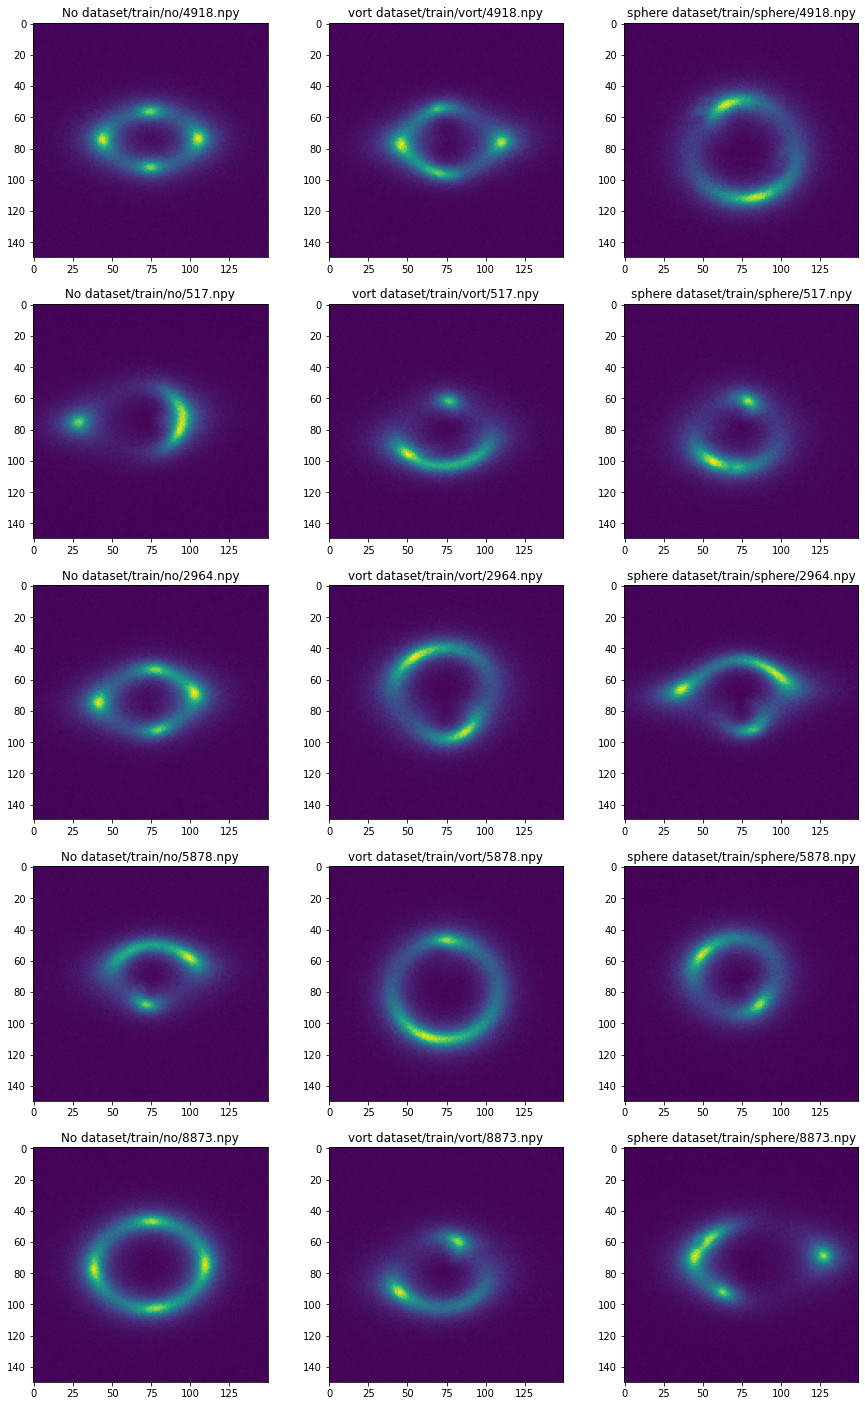

In [ ]:
n = 5
size = 5

idxes = np.random.permutation(np.arange(0, len(no)))[:n]

plt.figure(figsize=(3 * size, n * size))
for i,idx in enumerate(idxes): 
  no_ex = np.load(no[idx]).transpose(1, 2, 0)
  vort_ex = np.load(vort[idx]).transpose(1, 2, 0)
  sphere_ex = np.load(sphere[idx]).transpose(1,2,0)

  plt.subplot(n, 3,  3 * i + 1)
  plt.title(f"No {no[idx]}")
  plt.imshow(no_ex)

  plt.subplot(n, 3,  3 * i + 2)
  plt.title(f"vort {vort[idx]}")
  plt.imshow(vort_ex)

  plt.subplot(n, 3,  3 * i + 3)
  plt.title(f"sphere {sphere[idx]}")
  plt.imshow(sphere_ex)

plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Used : {device}")

Device Used : cuda:0


In [ ]:
def evaluate_model(model, valid_dataset, valid_dataset_len):
    since = time.time()

    # Each epoch has a training and validation phase
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    y = torch.Tensor()
    pred_y = torch.Tensor()
    criterion = nn.CrossEntropyLoss()

    # Iterate over data.
    for inputs, labels in tqdm(valid_dataset):
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        labels = labels.long()
        y = torch.cat([y, labels.cpu()])
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            probs, preds = torch.max(outputs, 1)
            
            #print(outputs.shape)
            loss = criterion(outputs, labels)

            pred_y = torch.cat([pred_y, outputs.cpu()])

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / valid_dataset_len
    epoch_acc = running_corrects.double() / valid_dataset_len
    AUC_ROC = roc_auc_score(y.detach().numpy(), F.softmax(pred_y, dim=1).detach().numpy(), multi_class="ovr")  

    
    time_elapsed = time.time() - since
    print(f'VALIDATION : Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since, 2)}')

In [ ]:
def training_epoch(model, optimizer, scheduler, 
                   train_dataloader, train_dataset_size,
                   valid_dataloader, valid_dataset_size, 
                   num_epochs=25, update_every=5,
                   clean_every = 10):
    since = time.time()

    returnDict = {"trainingLoss" : [], "trainingAccuracy" : [], "epochs" : [], "trainingAUC" : []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        since2 = time.time()
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0
        y = torch.Tensor()
        pred_y = torch.Tensor()
        criterion = nn.CrossEntropyLoss()

        i = 0
        samples_so_far = 0
        # Iterate over data.
        progress_bar = tqdm(train_dataloader)
        for inputs, labels in progress_bar:
            i += 1
            samples_so_far += inputs.shape[0]
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            labels = labels.long()

            y = torch.cat([y, labels.cpu()])
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                probs, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                pred_y = torch.cat([pred_y, outputs.cpu()])

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if i % update_every == 0:
                rl_avg = running_loss / samples_so_far
                acc_avg = running_corrects / samples_so_far
                AUC_ROC = roc_auc_score(y.detach().numpy(), F.softmax(pred_y, dim=1).detach().numpy(), multi_class="ovr")  

                progress_bar.set_description(f"loss = {rl_avg}, accuracy : {acc_avg}, AUC ROC {AUC_ROC}")
            
            if clean_every != -1 and i % clean_every == 0:
                gc.collect()

        scheduler.step()
        epoch_loss = running_loss / train_dataset_size
        epoch_acc = running_corrects.double() / train_dataset_size
        AUC_ROC = roc_auc_score(y.detach().numpy(), F.softmax(pred_y, dim=1).detach().numpy(), multi_class="ovr")  

        returnDict["trainingLoss"].append(epoch_loss)
        returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
        returnDict["trainingAUC"].append(AUC_ROC)

        print(f'TRAINING ; Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')
        evaluate_model(model, valid_dataloader, valid_dataset_size)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    returnDict["best_model"] = model
    return returnDict

In [ ]:
def plotResults(results):
    plt.figure(figsize=(16,12))
    plt.subplot(3,1, 1)
    plt.plot(results['epochs'], results['trainingLoss'], label="training Loss")
    plt.legend()

    plt.subplot(3,1, 2)
    plt.plot(results['epochs'], results['trainingAccuracy'], label="training Accuracy")
    plt.legend()
  
  
    plt.subplot(3,1, 3)
    plt.plot(results['epochs'], results['trainingAUC'], label="training ROC")
    plt.legend()

    plt.show()

In [ ]:
def doExperiment(model_ft, epochs=10, learning_rate=1e-3, plot=True, _summary=True, input_size=(3,32,32)):
  global train_dl, train_ds, val_dl, val_ds
  if _summary:
    print(summary(model_ft, input_size=input_size, device="cpu"))
  
  model_ft = model_ft.to(device)
  optim = pt_optim.Adam(model_ft.parameters(), lr=learning_rate)
  lr_sched = pt_lr_scheduler.StepLR(optim, 10, 0.9)

  dats = training_epoch(model_ft, optim, lr_sched, 
                        train_dl,  len(train_ds) , 
                        val_dl, len(val_ds),
                        num_epochs=epochs)
  
  if plot:
    plotResults(dats)
  return dats

In [ ]:
# Large dataset
mean = 0.06169275318411914
std = 0.1172684106873827
std = 1
batch_size = 32

_transforms = transforms.Compose([
    transforms.RandomRotation(180),
    transforms.Normalize(mean, std),
    transforms.Resize((128,128))
])

def load_npy(path : str) -> torch.Tensor:
    # load the image
    img = torch.from_numpy(np.load(path))

    # preprocess it     
    return _transforms(img)

train_ds = DatasetFolder(dataset_filepath_train, extensions=[".npy"], loader=load_npy)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = DatasetFolder(dataset_filepath_val, extensions=[".npy"], loader=load_npy)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

In [ ]:
print(f"size of training : {len(train_ds)}")
print(f"size of validation : {len(val_ds)}")

size of training : 30000
size of validation : 7500


torch.Size([32, 1, 128, 128]) torch.Size([32])
torch.Size([32, 1, 128, 128]) torch.Size([32])


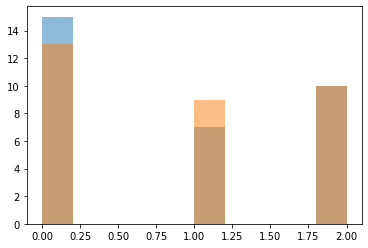

In [ ]:
next_train = next(iter(train_dl)) 
print(next_train[0].shape, next_train[1].shape)

next_val = next(iter(val_dl)) 
print(next_val[0].shape, next_val[1].shape)

plt.hist(next_train[1].numpy(), alpha=0.5)
plt.hist(next_val[1].numpy(), alpha=0.5)
plt.show()

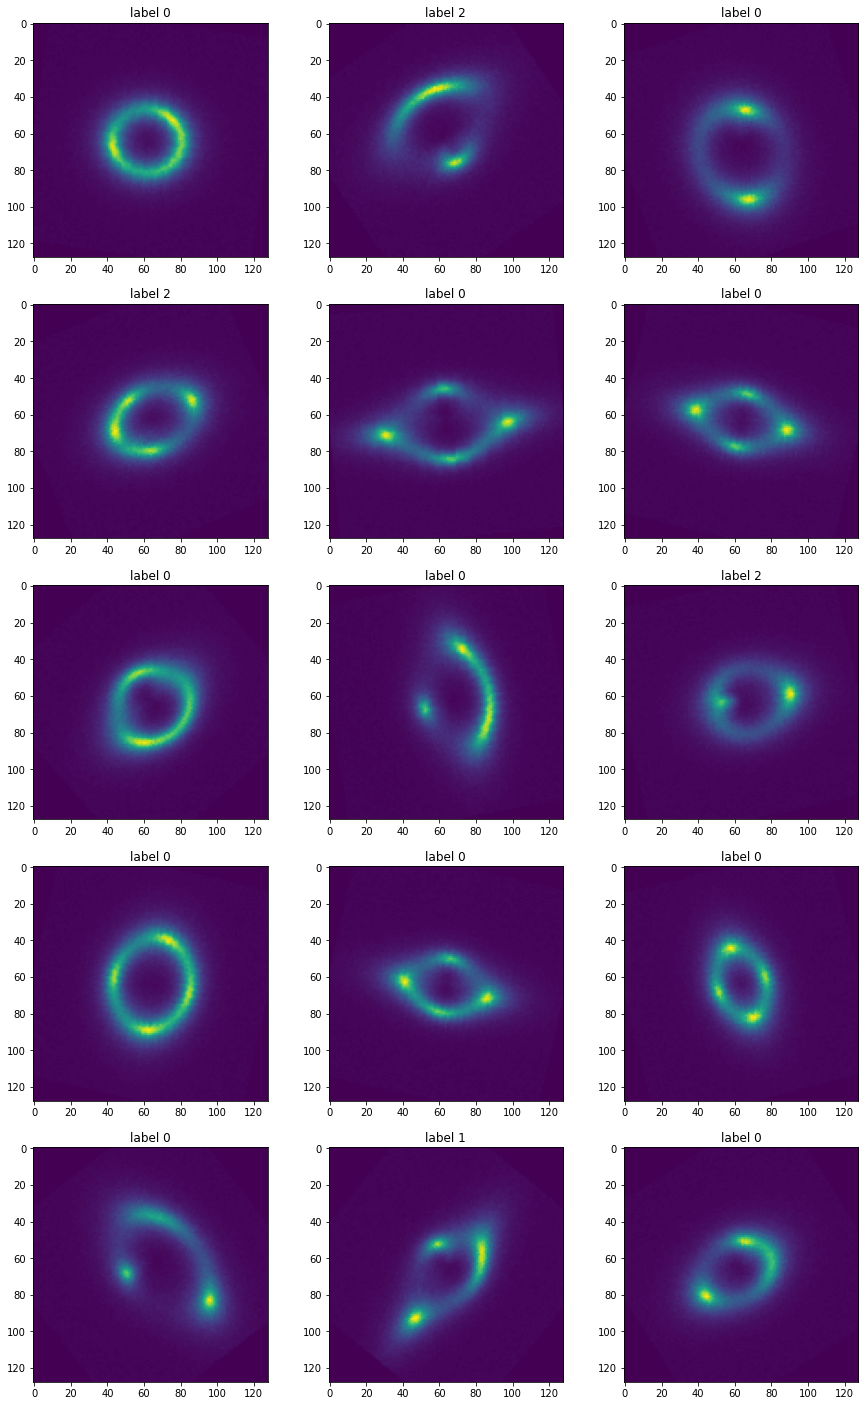

In [ ]:
n = 5
data_to_viz = next_train[0].numpy()[:3 * n].transpose(0, 2, 3, 1)
data_to_viz_label = next_train[1].numpy()


plt.figure(figsize=(3 * size, n * size))
for i,idx in enumerate(idxes): 
  im1, label1 = data_to_viz[3 * i], data_to_viz_label[3 * i]
  im2, label2 = data_to_viz[3 * i + 1], data_to_viz_label[3 * i + 1]
  im3, label3 = data_to_viz[3 * i + 2], data_to_viz_label[3 * i + 2]

  plt.subplot(n, 3,  3 * i + 1)
  plt.title(f"label {label1}")
  plt.imshow(im1)

  plt.subplot(n, 3,  3 * i + 2)
  plt.title(f"label {label2}")
  plt.imshow(im2)

  plt.subplot(n, 3,  3 * i + 3)
  plt.title(f"label {label3}")
  plt.imshow(im3)

plt.show()

# Training

In [ ]:
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor

class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(8192, 512),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 3))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        return out

doExperiment(VGG16(), 
             input_size=(1,150,150), learning_rate=1e-4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]             640
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
            Conv2d-4         [-1, 64, 150, 150]          36,928
       BatchNorm2d-5         [-1, 64, 150, 150]             128
              ReLU-6         [-1, 64, 150, 150]               0
         MaxPool2d-7           [-1, 64, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]          73,856
       BatchNorm2d-9          [-1, 128, 75, 75]             256
             ReLU-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 128, 75, 75]         147,584
      BatchNorm2d-12          [-1, 128, 75, 75]             256
             ReLU-13          [-1, 128, 75, 75]               0
        MaxPool2d-14          [-1, 128,

  0%|          | 0/938 [00:06<?, ?it/s]


KeyboardInterrupt: ignored

# Vision Transformer

In [ ]:
from vit_pytorch import SimpleViT

doExperiment(SimpleViT(image_size=128,
                        patch_size=15,
                        num_classes=3,
                        channels=1,
                        dim=128,
                        depth=2,
                        heads=4,
                        mlp_dim=256), 
             input_size=(1,128,128), learning_rate=1e-3)

AssertionError: ignored

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1             [-1, 16, 1024]               0
         LayerNorm-2             [-1, 16, 1024]           2,048
            Linear-3             [-1, 16, 1024]       1,049,600
         LayerNorm-4             [-1, 16, 1024]           2,048
           Dropout-5             [-1, 17, 1024]               0
         LayerNorm-6             [-1, 17, 1024]           2,048
            Linear-7             [-1, 17, 3072]       3,145,728
           Softmax-8           [-1, 16, 17, 17]               0
           Dropout-9           [-1, 16, 17, 17]               0
           Linear-10             [-1, 17, 1024]       1,049,600
          Dropout-11             [-1, 17, 1024]               0
        Attention-12             [-1, 17, 1024]               0
          PreNorm-13             [-1, 17, 1024]               0
        LayerNorm-14             [-1, 1

loss = 1.1123938931500847, accuracy : 0.3345922529697418, AUC ROC 0.501591650086374: 100%|██████████| 938/938 [02:15<00:00,  6.91it/s]


TRAINING ; Loss: 1.1124 Acc: 0.3346 AUC ROC : 0.5016 Time taken : 135.77


100%|██████████| 235/235 [00:22<00:00, 10.33it/s]


VALIDATION : Loss: 1.0989 Acc: 0.3384 AUC ROC : 0.5134 Time taken : 22.76
Epoch 1/9
----------


loss = 1.110912129840749, accuracy : 0.33522728085517883, AUC ROC 0.5035988877316938: 100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


TRAINING ; Loss: 1.1109 Acc: 0.3350 AUC ROC : 0.5035 Time taken : 136.35


100%|██████████| 235/235 [00:21<00:00, 10.69it/s]


VALIDATION : Loss: 1.1019 Acc: 0.3383 AUC ROC : 0.5048 Time taken : 21.99
Epoch 2/9
----------


loss = 1.110785546914779, accuracy : 0.33342245221138, AUC ROC 0.5019135757118643: 100%|██████████| 938/938 [02:15<00:00,  6.91it/s]


TRAINING ; Loss: 1.1108 Acc: 0.3334 AUC ROC : 0.5020 Time taken : 135.94


100%|██████████| 235/235 [00:22<00:00, 10.47it/s]


VALIDATION : Loss: 1.0993 Acc: 0.3363 AUC ROC : 0.5005 Time taken : 22.47
Epoch 3/9
----------


loss = 1.1094767232629705, accuracy : 0.33532753586769104, AUC ROC 0.502743487863082: 100%|██████████| 938/938 [02:15<00:00,  6.91it/s]


TRAINING ; Loss: 1.1095 Acc: 0.3353 AUC ROC : 0.5026 Time taken : 135.96


100%|██████████| 235/235 [00:22<00:00, 10.52it/s]


VALIDATION : Loss: 1.0994 Acc: 0.3421 AUC ROC : 0.5086 Time taken : 22.36
Epoch 4/9
----------


loss = 1.1092743605853401, accuracy : 0.33522728085517883, AUC ROC 0.5027526235854075: 100%|██████████| 938/938 [02:16<00:00,  6.88it/s]


TRAINING ; Loss: 1.1093 Acc: 0.3351 AUC ROC : 0.5026 Time taken : 136.45


100%|██████████| 235/235 [00:22<00:00, 10.62it/s]


VALIDATION : Loss: 1.1021 Acc: 0.3329 AUC ROC : 0.5070 Time taken : 22.15
Epoch 5/9
----------


loss = 1.1087273843785659, accuracy : 0.33502674102783203, AUC ROC 0.5032205563150104: 100%|██████████| 938/938 [02:16<00:00,  6.89it/s]


TRAINING ; Loss: 1.1087 Acc: 0.3350 AUC ROC : 0.5032 Time taken : 136.3


100%|██████████| 235/235 [00:22<00:00, 10.43it/s]


VALIDATION : Loss: 1.0993 Acc: 0.3335 AUC ROC : 0.5093 Time taken : 22.55
Epoch 6/9
----------


loss = 1.1068906005053596, accuracy : 0.33673128485679626, AUC ROC 0.5062637000282326: 100%|██████████| 938/938 [02:16<00:00,  6.87it/s]


TRAINING ; Loss: 1.1069 Acc: 0.3367 AUC ROC : 0.5063 Time taken : 136.62


100%|██████████| 235/235 [00:22<00:00, 10.57it/s]


VALIDATION : Loss: 1.1000 Acc: 0.3359 AUC ROC : 0.5144 Time taken : 22.25
Epoch 7/9
----------


loss = 1.1066667448390615, accuracy : 0.3386698067188263, AUC ROC 0.5061120023583687: 100%|██████████| 938/938 [02:16<00:00,  6.88it/s]


TRAINING ; Loss: 1.1067 Acc: 0.3386 AUC ROC : 0.5061 Time taken : 136.45


100%|██████████| 235/235 [00:22<00:00, 10.58it/s]


VALIDATION : Loss: 1.0999 Acc: 0.3413 AUC ROC : 0.5084 Time taken : 22.23
Epoch 8/9
----------


loss = 1.1073782599546056, accuracy : 0.3381350338459015, AUC ROC 0.5027185726904947: 100%|██████████| 938/938 [02:15<00:00,  6.91it/s]


TRAINING ; Loss: 1.1074 Acc: 0.3378 AUC ROC : 0.5025 Time taken : 135.95


100%|██████████| 235/235 [00:22<00:00, 10.31it/s]


VALIDATION : Loss: 1.0995 Acc: 0.3349 AUC ROC : 0.5116 Time taken : 22.81
Epoch 9/9
----------


loss = 1.1061997078319283, accuracy : 0.33579546213150024, AUC ROC 0.5044786898242929: 100%|██████████| 938/938 [02:17<00:00,  6.82it/s]


TRAINING ; Loss: 1.1062 Acc: 0.3358 AUC ROC : 0.5045 Time taken : 137.66


100%|██████████| 235/235 [00:22<00:00, 10.45it/s]


VALIDATION : Loss: 1.0983 Acc: 0.3421 AUC ROC : 0.5153 Time taken : 22.51
Training complete in 26m 28s


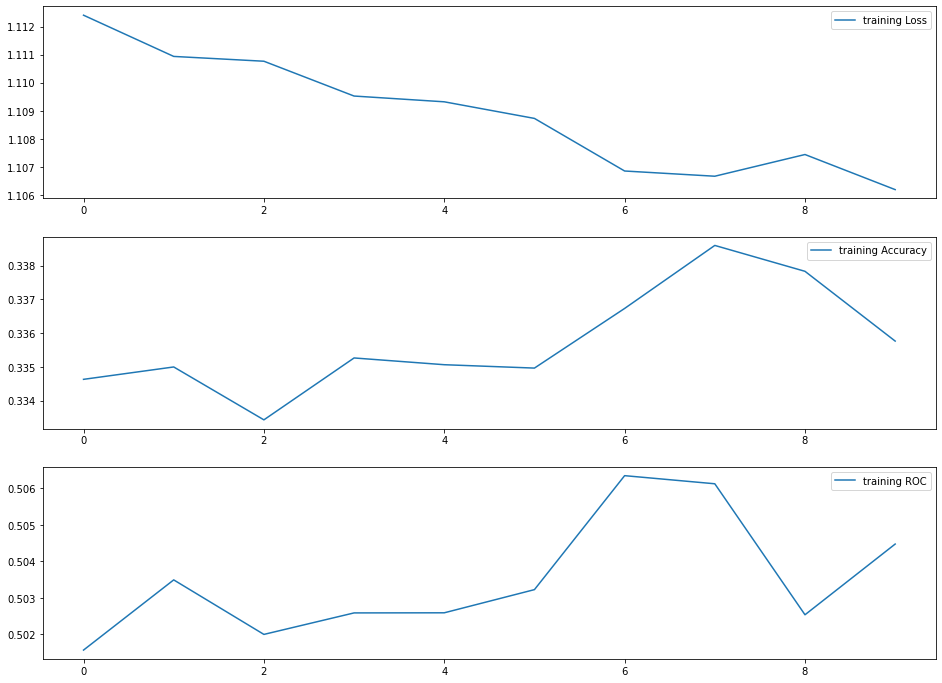

{'trainingLoss': [1.112407573890686,
  1.1109383204142254,
  1.1107668175379435,
  1.1095260384877523,
  1.1093205393473307,
  1.1087286428451537,
  1.1068538316090901,
  1.1066679210662842,
  1.1074416716257731,
  1.1061905457178751],
 'trainingAccuracy': [0.33463333333333334,
  0.335,
  0.33343333333333336,
  0.33526666666666666,
  0.3350666666666667,
  0.3349666666666667,
  0.33673333333333333,
  0.3386,
  0.3378333333333334,
  0.33576666666666666],
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'trainingAUC': [0.501570065,
  0.5034933008333334,
  0.5019995308333334,
  0.5025884825000001,
  0.5025915208333332,
  0.5032264725000001,
  0.506349115,
  0.5061268,
  0.5025377091666666,
  0.50447517],
 'best_model': ViT(
   (to_patch_embedding): Sequential(
     (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
     (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
     (2): Linear(in_features=1024, out_features=1024, bias=True)
     (3): LayerNorm((1024,), eps

In [ ]:
from vit_pytorch import ViT

doExperiment(ViT(image_size = 128,
              patch_size = 32,
              num_classes = 3,
              channels=1,
              dim = 1024,
              depth = 6,
              heads = 16,
              mlp_dim = 2048,
              dropout = 0.1,
              emb_dropout = 0.1), 
             input_size=(1,128,128), learning_rate=0.5e-6)